                     FileName Rhythm  VentricularRate  AtrialRate  \
0  MUSE_20180111_155115_19000     ST              126         126   
1  MUSE_20180111_155154_74000   AFIB              110         258   
2  MUSE_20180111_155203_15000   AFIB               59         416   
3  MUSE_20180111_155249_70000     ST              117         117   
4  MUSE_20180111_155542_84000     AF               88         352   

   QRSDuration  QTInterval  QTCorrected  RAxis  TAxis  QRSCount  QOnset  \
0          178         334          483    243     45        21     167   
1          102         276          373     84     20        18     222   
2           78         410          405     82     60        10     221   
3          144         354          493    -85     81        19     210   
4           70         362          438     87     22        15     225   

   QOffset  TOffset MergedRhythm  
0      256      334         GSVT  
1      273      360         AFIB  
2      260      426         A

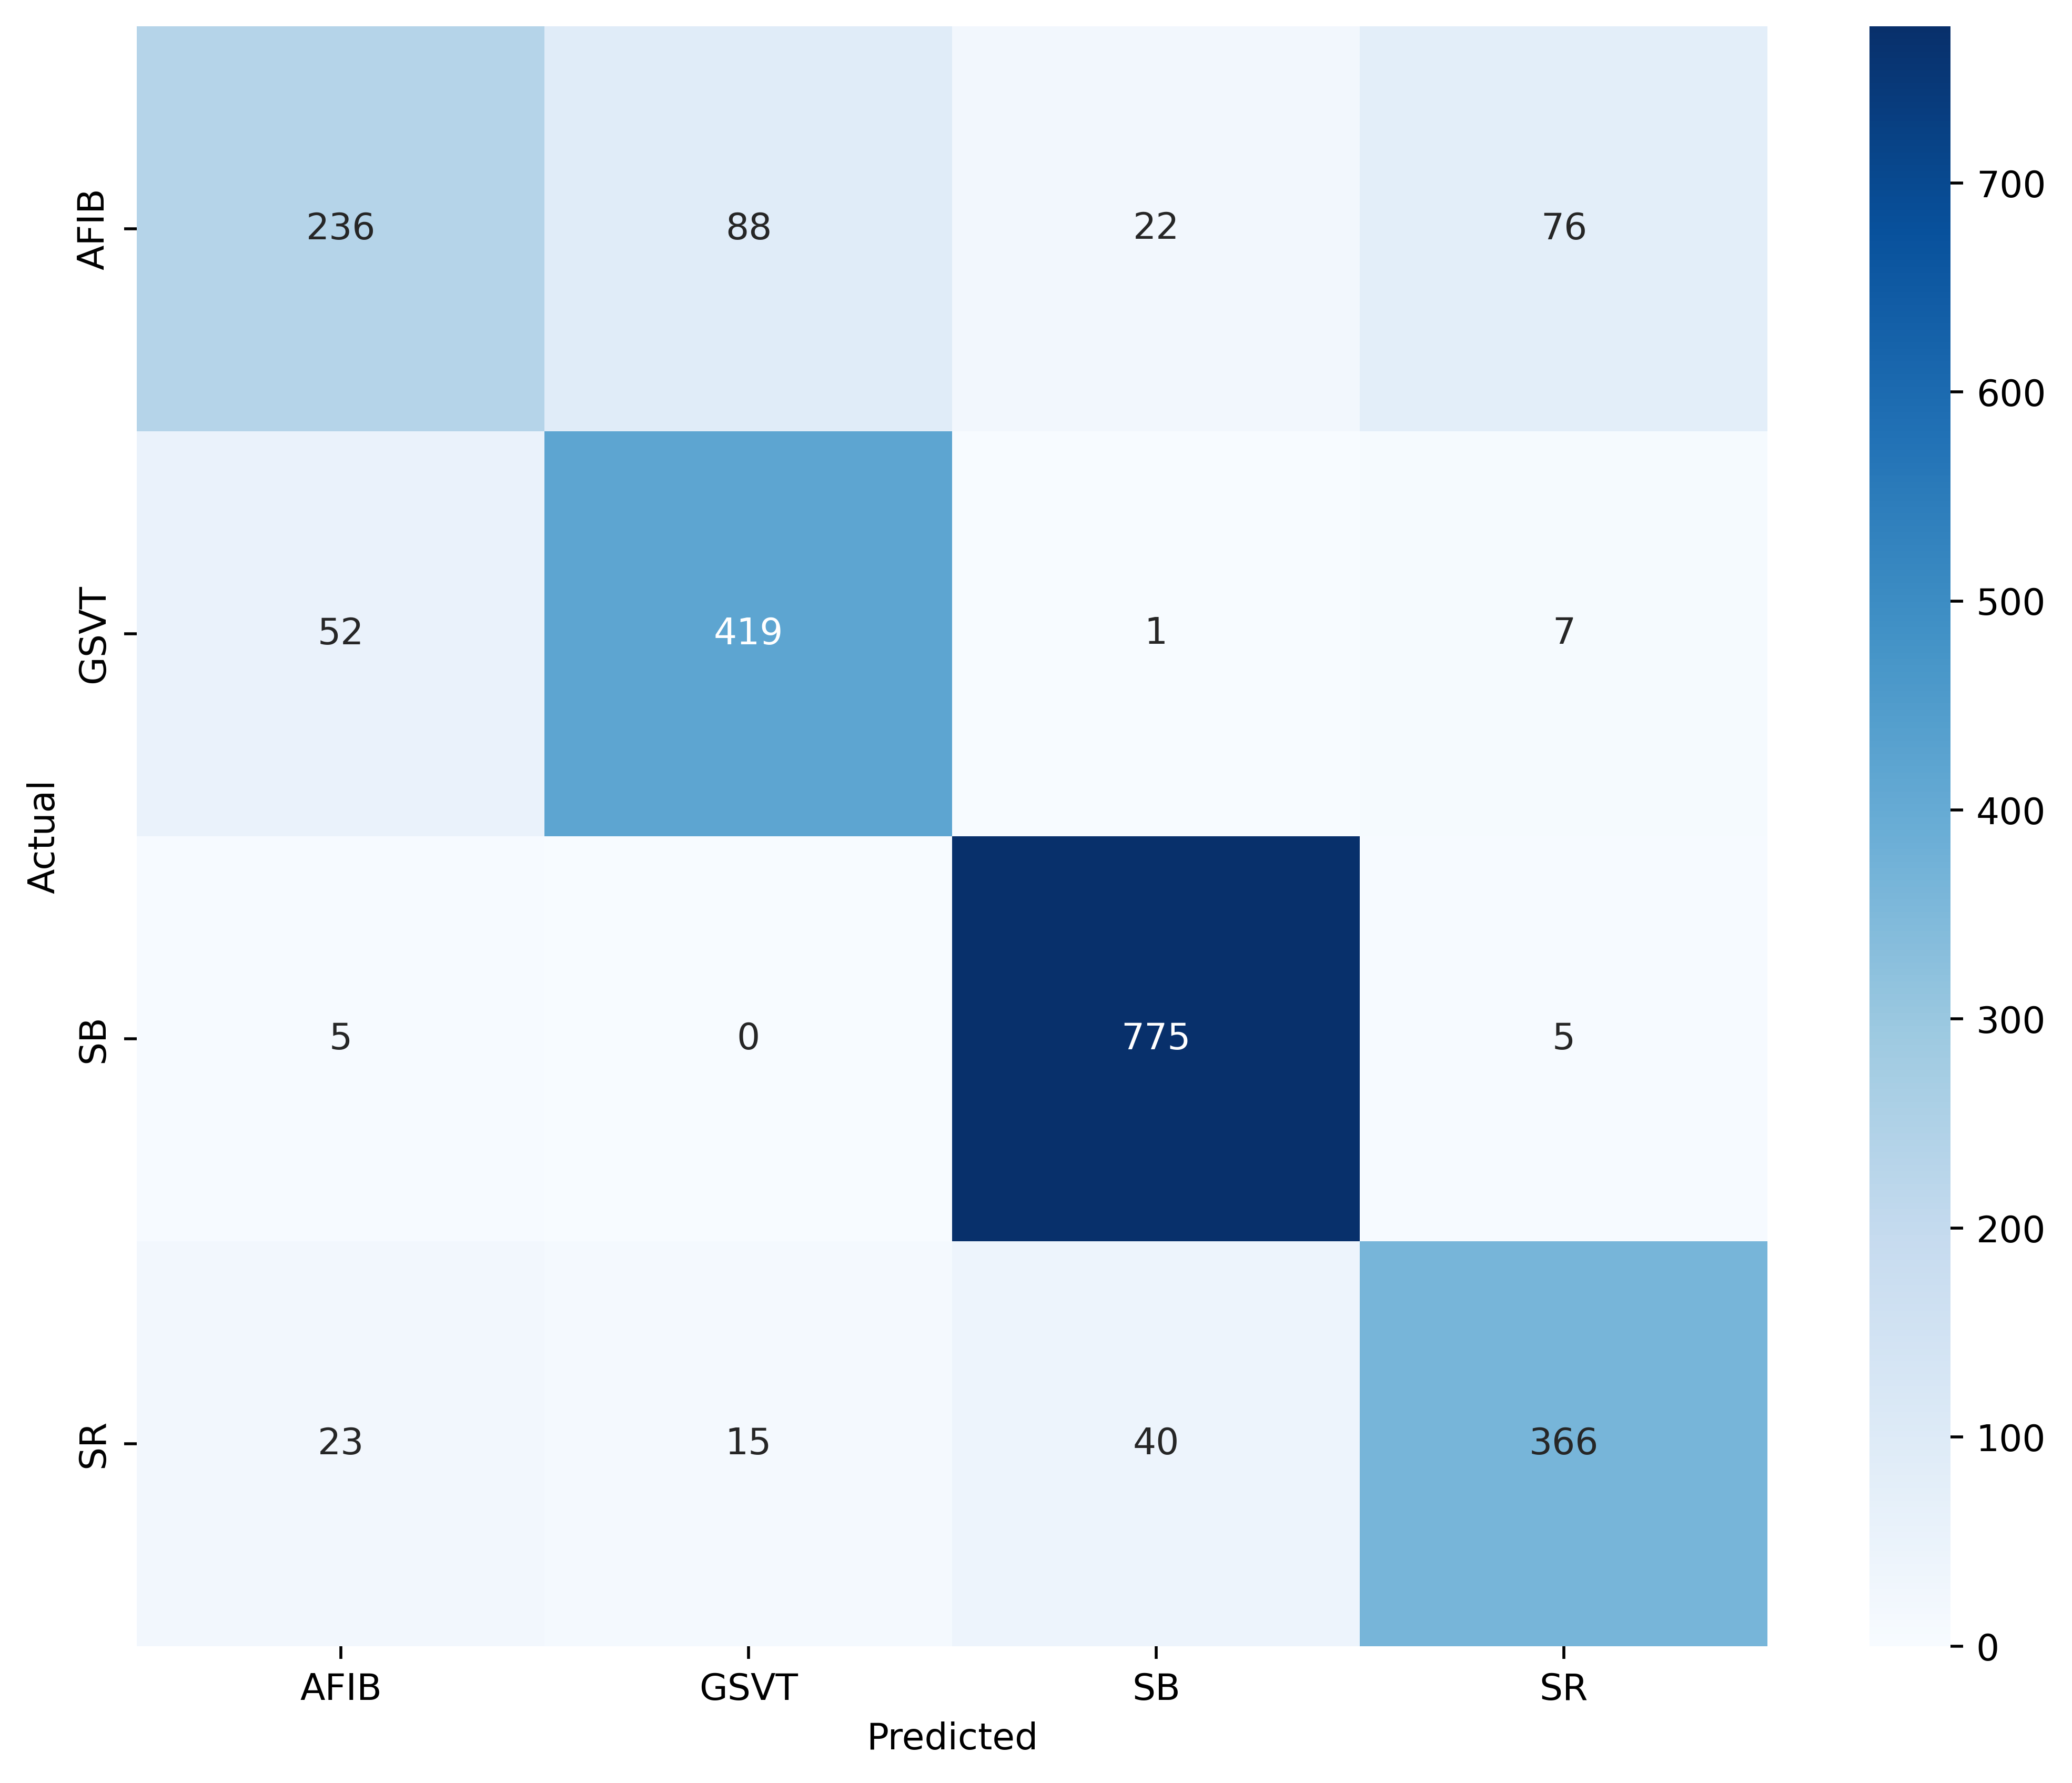

Predicted Rhythm for file MUSE_20180111_155115_19000: GSVT


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Load the dataset
df = pd.read_csv('FeatureExtractionParameters.csv', delimiter=';')

# Drop unnecessary columns
columns_to_drop = ['Beat', 'PatientAge', 'Gender']
existing_columns_to_drop = [col for col in columns_to_drop if col in df.columns]
df.drop(columns=existing_columns_to_drop, inplace=True)

# Merge Rhythm column categories
df['MergedRhythm'] = np.where(df['Rhythm'].isin(['AF', 'AFIB']), 'AFIB',
                               np.where(df['Rhythm'].isin(['SVT', 'AT', 'SAAWR', 'ST', 'AVNRT', 'AVRT']), 'GSVT',
                                        np.where(df['Rhythm'].isin(['SA', 'SR']), 'SR', 'SB')))

# Check the dataset
print(df.head())

# Prepare X and y variables
X = df.drop(columns=['Rhythm', 'MergedRhythm', 'FileName']).values
y = df['MergedRhythm'].values

# Label Encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create the KNN model
knn = KNeighborsClassifier(n_neighbors=5)

# Train the model
knn.fit(X_train_scaled, y_train)

# Evaluate the model on the test set
y_pred = knn.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Print confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Visualize confusion matrix
plt.figure(figsize=(10, 8),dpi=500)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Make a prediction for a specific file
specific_file = df[df['FileName'] == 'MUSE_20180111_155115_19000']

if not specific_file.empty:
    specific_file_features = specific_file.drop(columns=['Rhythm', 'MergedRhythm', 'FileName']).values
    specific_file_scaled = scaler.transform(specific_file_features)
    prediction = knn.predict(specific_file_scaled)
    predicted_label = label_encoder.inverse_transform(prediction)
    print(f"Predicted Rhythm for file MUSE_20180111_155115_19000: {predicted_label[0]}")
else:
    print("The specified file was not found.")
